In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import cvxopt
from pyswarm import pso
from sklearn.metrics import accuracy_score
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from cvxopt import matrix, solvers

import warnings
warnings.filterwarnings('ignore')


In [2]:
rs = 24

# Q1

## 1.1

In [114]:


X = np.array([
    [1, -1, 1],
    [-3, 1, 1],
    [-3, 1, -1],
    [1, 2, 1],
    [-1, -1, 2]
], dtype=float)

y = np.array([-1, 1, -1, -1, 1], dtype=float)

n_samples = X.shape[0]


K = np.dot(X, X.T)
Q = np.outer(y, y) * K


P = matrix(Q)
q = matrix(-np.ones(n_samples))
G = matrix(-np.eye(n_samples))
h = matrix(np.zeros(n_samples))
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))


sol = solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(sol['x'])


support_vectors_idx = np.where(alphas > 1e-5)[0]
alphas_sv = alphas[support_vectors_idx]
X_sv = X[support_vectors_idx]
y_sv = y[support_vectors_idx]


w = np.sum(alphas_sv[:, None] * y_sv[:, None] * X_sv, axis=0)
b = np.mean([y_sv[i] - np.dot(w, X_sv[i]) for i in range(len(X_sv))])

print("w:", w)
print("b:", b)


w: [-5.00000183e-01 -2.77304760e-07  1.00000005e+00]
b: -1.5000001123456355


## 1.2

### 1.2.2

In [3]:
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [4]:
data.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [5]:
data.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


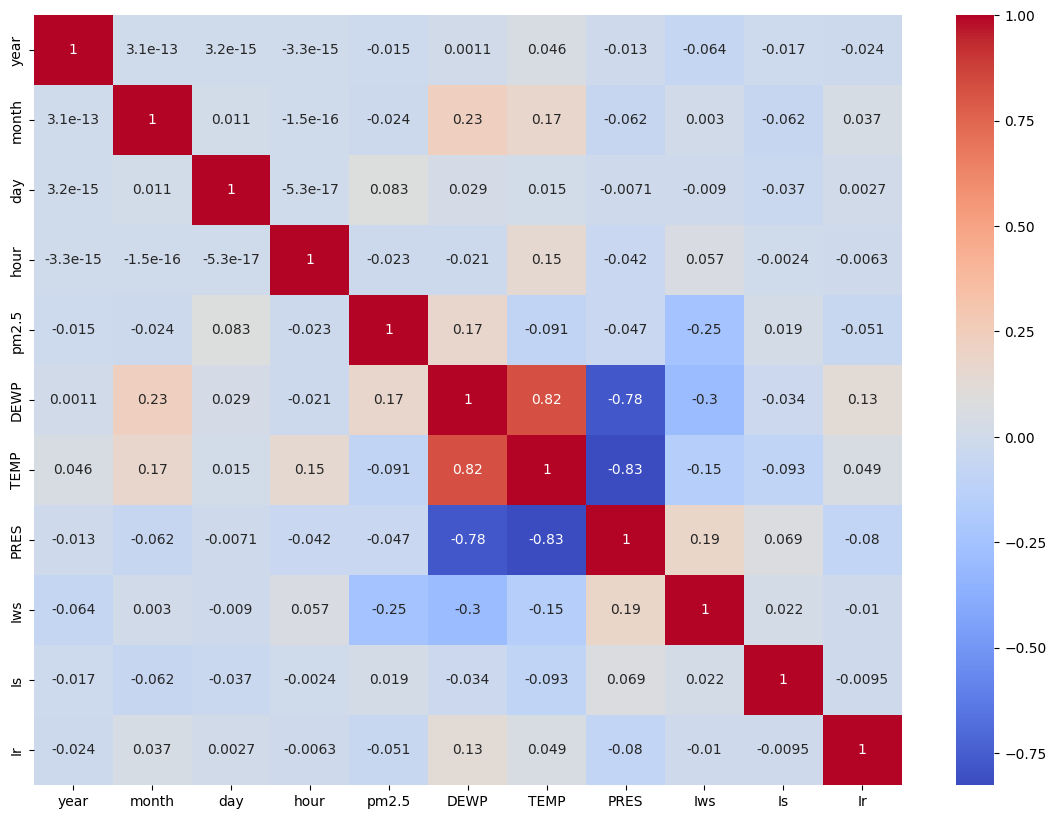

In [6]:
correlation_matrix = data.drop(['No','cbwd'],axis=1).corr()
plt.figure(figsize = (14,10))
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True)
plt.show()

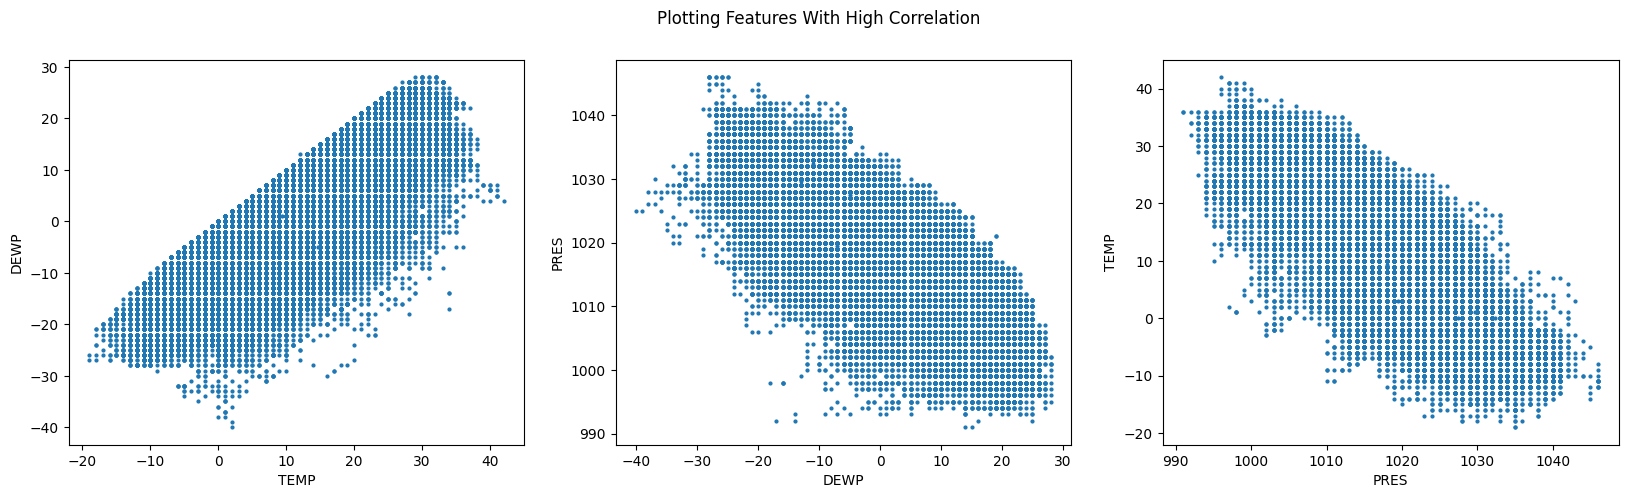

In [7]:
plot_index=['DEWP','PRES','TEMP']
plt.figure(figsize = (20,5))


for i in range (0,3):
    plt.subplot(1,3,i+1)
    plt.scatter(data[plot_index[i-1]].values,data[plot_index[i]].values,s=4)
    plt.xlabel(plot_index[i-1])
    plt.ylabel(plot_index[i])
plt.suptitle('Plotting Features With High Correlation')
plt.show()

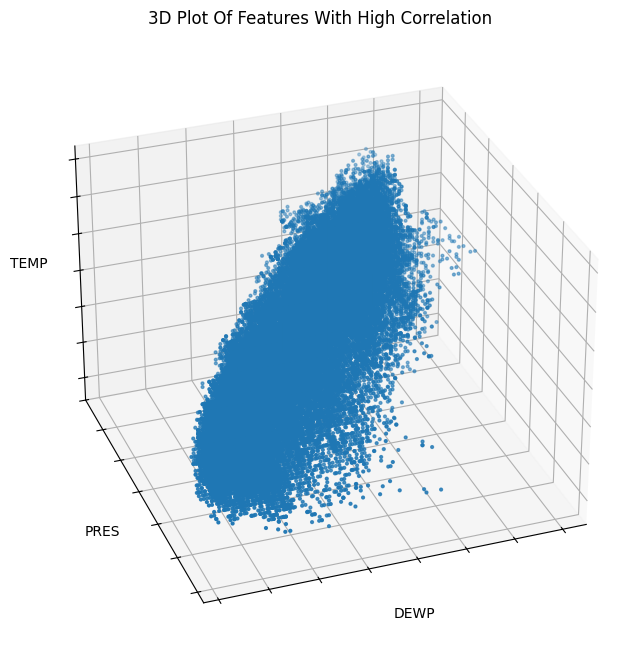

In [8]:

fig = plt.figure(1, figsize=(8, 12))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)


ax.scatter(
    data['DEWP'].values,
    data['PRES'].values,
    data['TEMP'].values,
    s=4,
)

ax.set_title("3D Plot Of Features With High Correlation")
ax.set_xlabel("DEWP")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("PRES")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("TEMP")
ax.zaxis.set_ticklabels([])

plt.show()

### 1.2.3

In [9]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [10]:
data.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [11]:
data['pm2.5'].describe()

count    41757.000000
mean        98.613215
std         92.050387
min          0.000000
25%         29.000000
50%         72.000000
75%        137.000000
max        994.000000
Name: pm2.5, dtype: float64

In [12]:
data['pm2.5'].value_counts()

pm2.5
16.0     626
11.0     596
13.0     589
12.0     578
17.0     572
        ... 
558.0      1
607.0      1
491.0      1
524.0      1
580.0      1
Name: count, Length: 581, dtype: int64

In [13]:
data.iloc[0:25]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [14]:
data=data.iloc[24:].reset_index(drop=True)
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [15]:
data.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2043
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [16]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [17]:
data.isna().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

### 1.2.4

In [18]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [19]:
data['cbwd'].value_counts()

cbwd
SE    15290
NW    14130
cv     9384
NE     4996
Name: count, dtype: int64

In [20]:
# Label encode the 'cbwd' column
data['cbwd_code'] = data['cbwd'].astype('category').cat.codes
cbwd_mapping = dict(enumerate(data['cbwd'].astype('category').cat.categories))
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_code
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,1
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,1
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,1
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,1


In [21]:
cbwd_mapping

{0: 'NE', 1: 'NW', 2: 'SE', 3: 'cv'}

In [22]:
data['cbwd_code'].value_counts()

cbwd_code
2    15290
1    14130
3     9384
0     4996
Name: count, dtype: int64

### 1.2.5

In [23]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_code
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,1
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,1
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,1
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,1


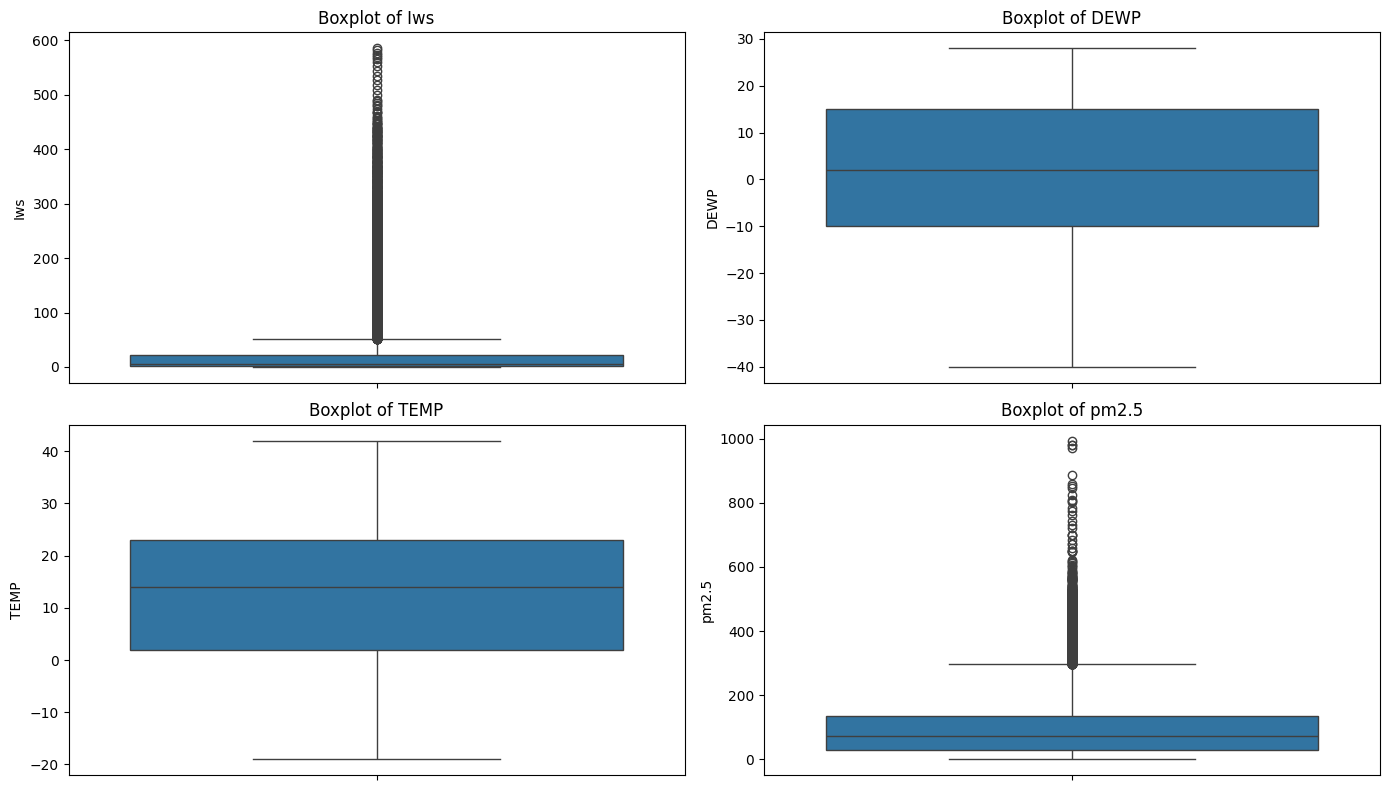

In [24]:
columns_to_check = ['Iws', 'DEWP', 'TEMP', 'pm2.5']
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_check):
    sns.boxplot(data=data, y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [25]:


def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df.reset_index(drop=True)


columns_to_clean = ['pm2.5', 'Iws', 'DEWP']
data_cleaned = remove_outliers_iqr(data, columns_to_clean)
#data = remove_outliers_iqr(data, columns_to_clean)



In [26]:
#data = data_cleaned
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_code
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,1
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,1
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,1
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,1


### 1.2.6

In [27]:
def categorize_pm25(value):
    if value <= 12.0:
        return 'Good'
    elif value <= 35.4:
        return 'Moderate'
    elif value <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif value <= 150.4:
        return 'Unhealthy'
    elif value <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'


data['pm25_category'] = data['pm2.5'].apply(categorize_pm25)


In [28]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_code,pm25_category
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2,Unhealthy
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2,Unhealthy
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,Very Unhealthy
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2,Very Unhealthy
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,1,Good
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,1,Good
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,1,Good
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,1,Good


In [29]:
data['pm25_category'].value_counts()

pm25_category
Unhealthy                         16405
Moderate                           9151
Very Unhealthy                     6160
Unhealthy for Sensitive Groups     5267
Good                               3707
Hazardous                          3110
Name: count, dtype: int64

### 1.2.7

#### Lag

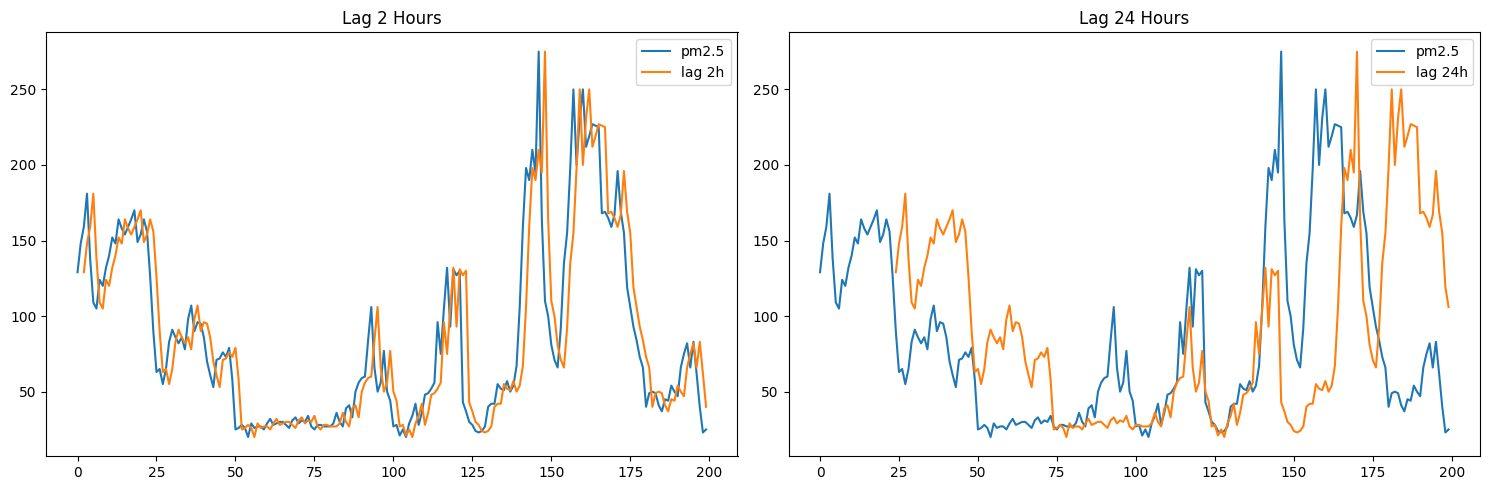

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_code,pm25_category,pm2.5_lag2,pm2.5_lag24
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2,Unhealthy,NaN,NaN
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2,Unhealthy,NaN,NaN
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,Very Unhealthy,129.0,NaN
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2,Very Unhealthy,148.0,NaN
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2,Unhealthy,159.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,1,Good,9.0,35.0
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,1,Good,10.0,26.0
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,1,Good,8.0,20.0
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,1,Good,10.0,8.0


In [30]:
data['pm2.5_lag2'] = data['pm2.5'].shift(2)
data['pm2.5_lag24'] = data['pm2.5'].shift(24)


plt.figure(figsize=(15,5 ))

plt.subplot(1, 2, 1)
plt.plot(data['pm2.5'].iloc[:200], label='pm2.5')
plt.plot(data['pm2.5_lag2'].iloc[:200], label='lag 2h')
plt.title('Lag 2 Hours')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data['pm2.5'].iloc[:200], label='pm2.5')
plt.plot(data['pm2.5_lag24'].iloc[:200], label='lag 24h')
plt.title('Lag 24 Hours')
plt.legend()

plt.tight_layout()
plt.show()


data


In [31]:
"""data=data.iloc[24:].reset_index(drop=True)
data"""

'data=data.iloc[24:].reset_index(drop=True)\ndata'

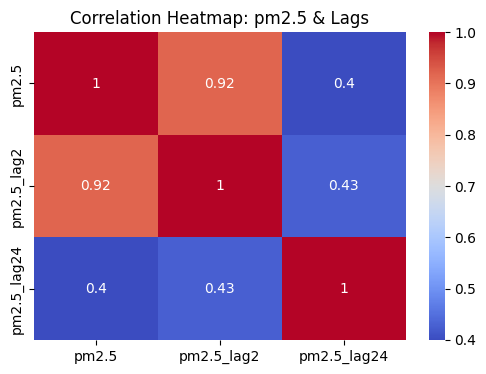

In [32]:

corr_matrix = data[['pm2.5', 'pm2.5_lag2', 'pm2.5_lag24']].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: pm2.5 & Lags')
plt.show()


In [33]:
data['pm25_category'].value_counts()

pm25_category
Unhealthy                         16405
Moderate                           9151
Very Unhealthy                     6160
Unhealthy for Sensitive Groups     5267
Good                               3707
Hazardous                          3110
Name: count, dtype: int64

In [34]:
lag_list=['DEWP','TEMP','PRES']

for i in lag_list:
    data[f'{i}_lag2'] = data[i].shift(2)
    data[f'{i}_lag24'] = data[i].shift(24)


data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,cbwd_code,pm25_category,pm2.5_lag2,pm2.5_lag24,DEWP_lag2,DEWP_lag24,TEMP_lag2,TEMP_lag24,PRES_lag2,PRES_lag24
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,2,Unhealthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,2,Unhealthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,2,Very Unhealthy,129.0,NaN,-16.0,NaN,-4.0,NaN,1020.0,NaN
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,2,Very Unhealthy,148.0,NaN,-15.0,NaN,-4.0,NaN,1020.0,NaN
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,2,Unhealthy,159.0,NaN,-11.0,NaN,-5.0,NaN,1021.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,1,Good,9.0,35.0,-22.0,-8.0,-1.0,6.0,1033.0,1021.0
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,1,Good,10.0,26.0,-22.0,-11.0,-2.0,5.0,1033.0,1022.0
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,1,Good,8.0,20.0,-23.0,-12.0,-2.0,4.0,1034.0,1023.0
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,1,Good,10.0,8.0,-22.0,-21.0,-3.0,2.0,1034.0,1025.0


#### Rolling Statistics

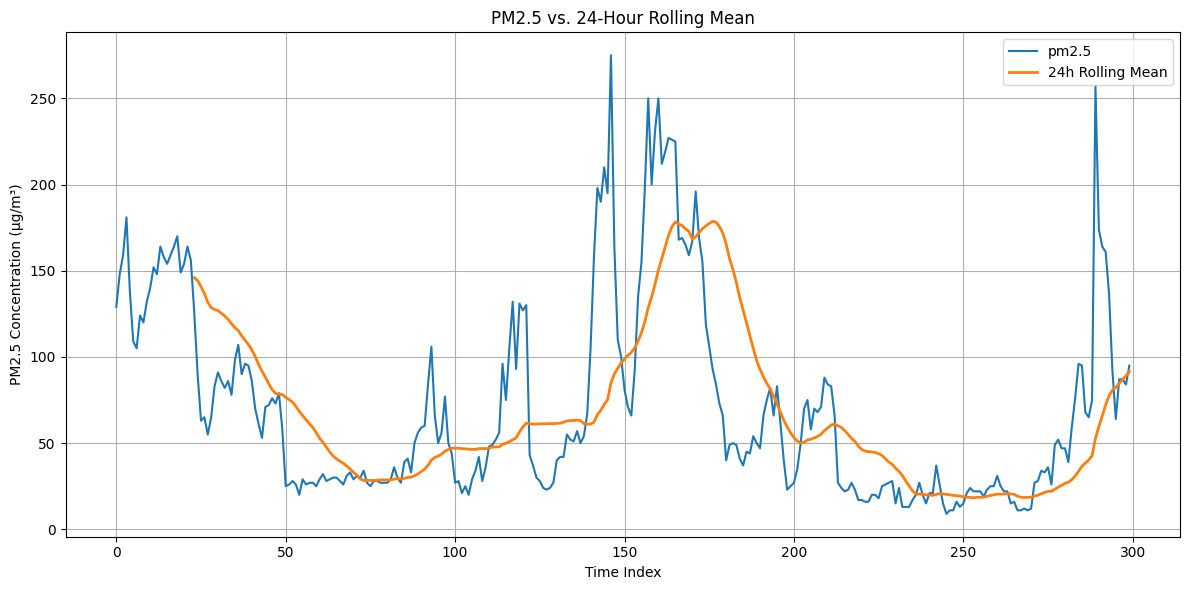

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,pm25_category,pm2.5_lag2,pm2.5_lag24,DEWP_lag2,DEWP_lag24,TEMP_lag2,TEMP_lag24,PRES_lag2,PRES_lag24,pm2.5_roll_mean_24h
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,Unhealthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,Unhealthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,Very Unhealthy,129.0,NaN,-16.0,NaN,-4.0,NaN,1020.0,NaN,NaN
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,Very Unhealthy,148.0,NaN,-15.0,NaN,-4.0,NaN,1020.0,NaN,NaN
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,Unhealthy,159.0,NaN,-11.0,NaN,-5.0,NaN,1021.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,Good,9.0,35.0,-22.0,-8.0,-1.0,6.0,1033.0,1021.0,11.291667
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,Good,10.0,26.0,-22.0,-11.0,-2.0,5.0,1033.0,1022.0,10.625000
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,Good,8.0,20.0,-23.0,-12.0,-2.0,4.0,1034.0,1023.0,10.208333
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,Good,10.0,8.0,-22.0,-21.0,-3.0,2.0,1034.0,1025.0,10.208333


In [ ]:

data['pm2.5_roll_mean_24h'] = data['pm2.5'].rolling(window=24).mean()


# رسم نمودار
plt.figure(figsize=(12, 6))
plt.plot(data['pm2.5'].iloc[:300], label='pm2.5')
plt.plot(data['pm2.5_roll_mean_24h'].iloc[:300], label='24h Rolling Mean', linewidth=2)
plt.title('PM2.5 vs. 24-Hour Rolling Mean')
plt.xlabel('Time Index')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

data


In [36]:
data['pm2.5_roll_mean_24h'].isna().sum()

23

In [ ]:



def rolling_rms(x):
    return np.sqrt(np.mean(np.square(x)))


def rolling_crest_factor(x):
    return np.max(np.abs(x)) / (np.sqrt(np.mean(np.square(x))) + 1e-9)

"""# تابع محاسبه Zero Crossing Rate
def rolling_zero_crossing_rate(x):
    return ((np.diff(np.sign(x)) != 0).sum()) / len(x)
"""

def rolling_time_entropy(x):
    hist, bin_edges = np.histogram(x, bins=10, density=True)
    return entropy(hist + 1e-9)  


rolling_window = 24

# محاسبه ویژگی‌ها
data['pm2.5_roll_std'] = data['pm2.5'].rolling(window=rolling_window).std()
data['pm2.5_roll_rms'] = data['pm2.5'].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data['pm2.5_roll_peak'] = data['pm2.5'].rolling(window=rolling_window).max()
data['pm2.5_roll_crest'] = data['pm2.5'].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data['pm2.5_roll_entropy'] = data['pm2.5'].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)


a1="PRES"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)



a1="DEWP"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)



a1="TEMP"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)


a1="Iws"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)

a1="Is"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)


a1="Ir"
data[f'{a1}_roll_mean_24h'] = data[a1].rolling(window=24).mean()
data[f'{a1}_roll_std'] = data[a1].rolling(window=rolling_window).std()
data[f'{a1}_roll_rms'] = data[a1].rolling(window=rolling_window).apply(rolling_rms, raw=True)
data[f'{a1}_roll_peak'] = data[a1].rolling(window=rolling_window).max()
data[f'{a1}_roll_crest'] = data[a1].rolling(window=rolling_window).apply(rolling_crest_factor, raw=True)

data[f'{a1}_roll_entropy'] = data[a1].rolling(window=rolling_window).apply(rolling_time_entropy, raw=True)





In [38]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,0.0,0.0,0.0,2.162327e-08,0.0,0.0,0.0,0.0,0.0,2.162327e-08
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,0.0,0.0,0.0,2.162327e-08,0.0,0.0,0.0,0.0,0.0,2.162327e-08
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,0.0,0.0,0.0,2.162327e-08,0.0,0.0,0.0,0.0,0.0,2.162327e-08
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,0.0,0.0,0.0,2.162327e-08,0.0,0.0,0.0,0.0,0.0,2.162327e-08


#### Periodic

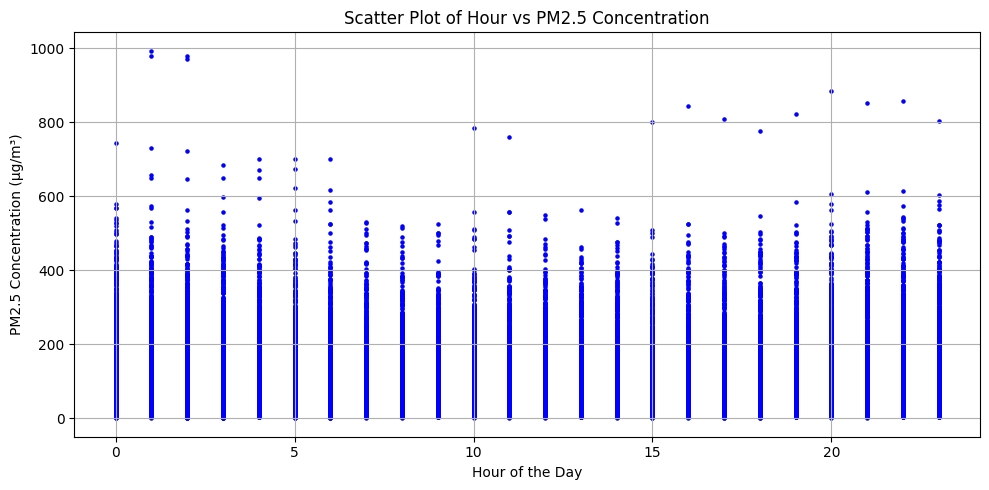

In [ ]:

data['datetime'] = pd.to_datetime(dict(
    year=data['year'],
    month=data['month'],
    day=data['day'],
    hour=data['hour']
))


data['weekday'] = data['datetime'].dt.weekday  # Monday = 0, Sunday = 6


periodic_features = ['hour', 'month', 'day', 'weekday']
periods = [24, 12, 31, 7]

for feature, period in zip(periodic_features, periods):
    data[f'{feature}_sin'] = np.sin(2 * np.pi * data[feature] / period)
    data[f'{feature}_cos'] = np.cos(2 * np.pi * data[feature] / period)


plt.figure(figsize=(10, 5))
plt.scatter(data['hour'], data['pm2.5'], alpha=1, s=5, c='blue')
plt.title('Scatter Plot of Hour vs PM2.5 Concentration')
plt.xlabel('Hour of the Day')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,datetime,weekday,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,2010-01-02 00:00:00,5,0.000000,1.000000,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,2010-01-02 01:00:00,5,0.258819,0.965926,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,2010-01-02 02:00:00,5,0.500000,0.866025,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,2010-01-02 03:00:00,5,0.707107,0.707107,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,2010-01-02 04:00:00,5,0.866025,0.500000,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,2014-12-31 19:00:00,2,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,2014-12-31 20:00:00,2,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,2014-12-31 21:00:00,2,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,2014-12-31 22:00:00,2,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521


#### Advanced Time features

In [ ]:
import seaborn as sns


def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

data['season'] = data['month'].apply(get_season)


seasonal_avg = data.groupby('season')['pm2.5'].mean().sort_values(ascending=False)


weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
data['weekday_name'] = data['weekday'].map(weekday_map)
weekday_avg = data.groupby('weekday_name')['pm2.5'].mean().sort_values(ascending=False)


correlations = data[['pm2.5', 'PRES', 'TEMP', 'Iws']].corr()['pm2.5'].sort_values(ascending=False)


hourly_avg = data.groupby('hour')['pm2.5'].mean()

seasonal_avg, weekday_avg, correlations, hourly_avg


(season
 Winter    109.872500
 Autumn    101.582509
 Summer     91.739764
 Spring     88.245380
 Name: pm2.5, dtype: float64,
 weekday_name
 Saturday     103.153736
 Friday        99.845353
 Sunday        98.595945
 Wednesday     97.284483
 Thursday      96.920353
 Tuesday       96.249840
 Monday        92.443008
 Name: pm2.5, dtype: float64,
 pm2.5    1.000000
 PRES    -0.057439
 TEMP    -0.077869
 Iws     -0.243067
 Name: pm2.5, dtype: float64,
 hour
 0     111.600000
 1     112.373699
 2     109.892055
 3     107.065205
 4     103.192329
 5      99.828493
 6      96.710685
 7      95.606027
 8      95.404384
 9      93.964932
 10     92.627397
 11     91.134795
 12     89.059178
 13     87.403836
 14     85.846575
 15     85.021370
 16     85.423562
 17     86.895890
 18     90.675616
 19     96.333151
 20    103.086027
 21    107.815890
 22    109.540822
 23    110.314521
 Name: pm2.5, dtype: float64)

In [42]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,0.000000,1.000000,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,Winter,Saturday
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,0.258819,0.965926,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,Winter,Saturday
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,0.500000,0.866025,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,Winter,Saturday
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,0.707107,0.707107,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,Winter,Saturday
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,0.866025,0.500000,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,Winter,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43796,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43797,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43798,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday


In [43]:
data['pm2.5_lag24'].isna().sum()

24

### 1.2.8

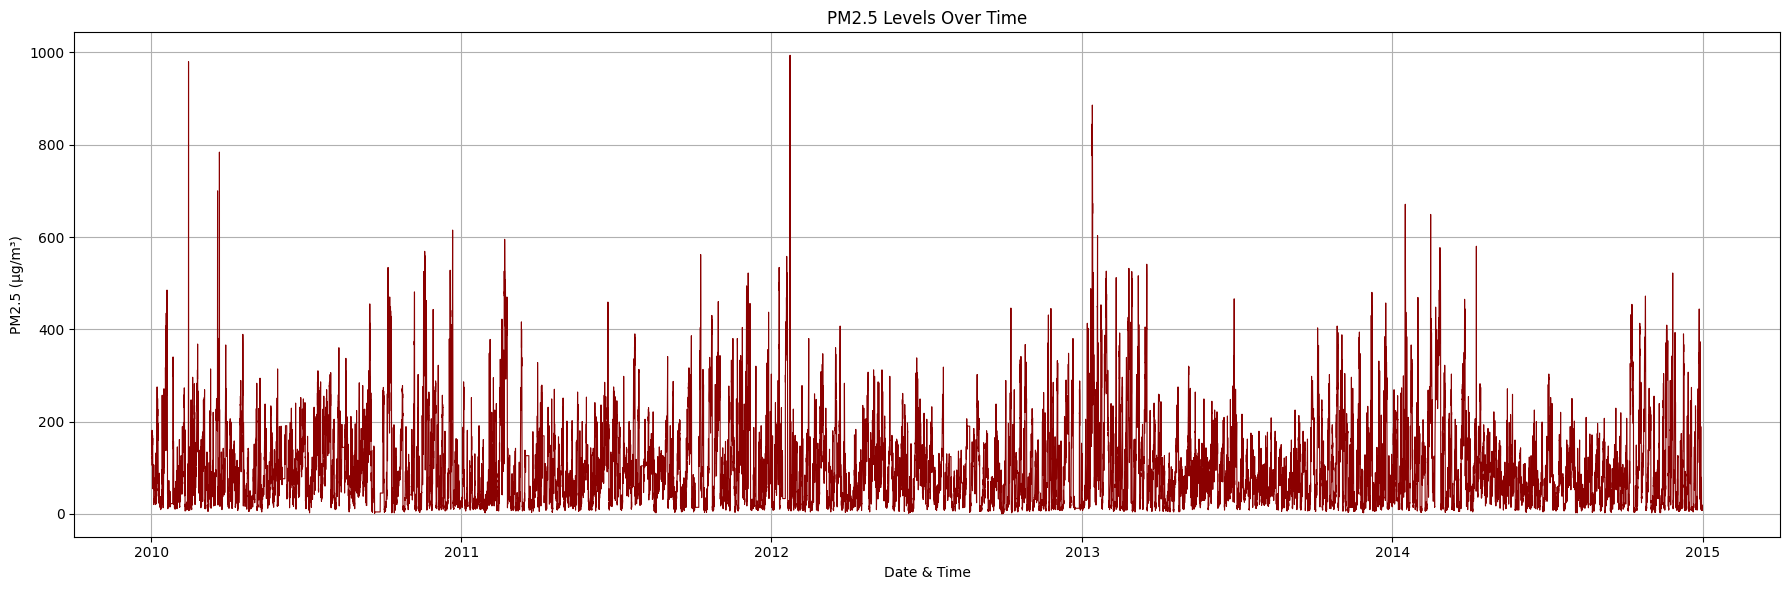

(datetime    2012-01-23 01:00:00
 pm2.5                     994.0
 Name: 18025, dtype: object,
 109.9659090909091,
 95.0244623655914)

In [44]:

# Create datetime column
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# Plot PM2.5 over time
plt.figure(figsize=(18, 6))
sns.lineplot(data=data, x='datetime', y='pm2.5', color='darkred', linewidth=0.8)
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date & Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Find date with highest PM2.5
max_pm25_row = data.loc[data['pm2.5'].idxmax()][['datetime', 'pm2.5']]

# Average PM2.5 in January and December
monthly_avg_pm25 = data.groupby('month')['pm2.5'].mean()
january_avg = monthly_avg_pm25[1]
december_avg = monthly_avg_pm25[12]

max_pm25_row, january_avg, december_avg


In [45]:
data=data.iloc[24:].reset_index(drop=True)
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,49,2010,1,3,0,90.0,-7,-6.0,1027.0,SE,...,0.000000,1.000000,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
1,50,2010,1,3,1,63.0,-8,-6.0,1026.0,SE,...,0.258819,0.965926,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
2,51,2010,1,3,2,65.0,-8,-7.0,1026.0,SE,...,0.500000,0.866025,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
3,52,2010,1,3,3,55.0,-8,-7.0,1025.0,SE,...,0.707107,0.707107,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
4,53,2010,1,3,4,65.0,-8,-7.0,1024.0,SE,...,0.866025,0.500000,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43772,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43773,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43774,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday


In [46]:
data['pm2.5_lag24'].isna().sum()

0

### 1.2.9

In [47]:
class_counts = data['pm25_category'].value_counts()
class_counts


pm25_category
Unhealthy                         16393
Moderate                           9151
Very Unhealthy                     6148
Unhealthy for Sensitive Groups     5267
Good                               3707
Hazardous                          3110
Name: count, dtype: int64

In [48]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [data[data['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = class_counts.min()

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
balanced_data = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = balanced_data['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         3110
Moderate                          3110
Very Unhealthy                    3110
Unhealthy for Sensitive Groups    3110
Good                              3110
Hazardous                         3110
Name: count, dtype: int64

In [49]:
balanced_data
balanced_data.to_csv('balanced_data.csv',index=False)

In [50]:
data.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'cbwd_code', 'pm25_category', 'pm2.5_lag2',
       'pm2.5_lag24', 'DEWP_lag2', 'DEWP_lag24', 'TEMP_lag2', 'TEMP_lag24',
       'PRES_lag2', 'PRES_lag24', 'pm2.5_roll_mean_24h', 'pm2.5_roll_std',
       'pm2.5_roll_rms', 'pm2.5_roll_peak', 'pm2.5_roll_crest',
       'pm2.5_roll_entropy', 'PRES_roll_mean_24h', 'PRES_roll_std',
       'PRES_roll_rms', 'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h', 'TEMP_roll_std',
       'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy', 'Iws_roll_mean_24h', 'Iws_roll_std',
       'Iws_roll_rms', 'Iws_roll_peak', 'Iws_roll_crest', 'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest', 'Is_

In [51]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,49,2010,1,3,0,90.0,-7,-6.0,1027.0,SE,...,0.000000,1.000000,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
1,50,2010,1,3,1,63.0,-8,-6.0,1026.0,SE,...,0.258819,0.965926,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
2,51,2010,1,3,2,65.0,-8,-7.0,1026.0,SE,...,0.500000,0.866025,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
3,52,2010,1,3,3,55.0,-8,-7.0,1025.0,SE,...,0.707107,0.707107,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
4,53,2010,1,3,4,65.0,-8,-7.0,1024.0,SE,...,0.866025,0.500000,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,Winter,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43772,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43773,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday
43774,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,Winter,Wednesday


In [52]:
balanced_data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


### 1.2.12

In [75]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [76]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'cbwd_code', 'pm25_category', 'pm2.5_lag2',
       'pm2.5_lag24', 'DEWP_lag2', 'DEWP_lag24', 'TEMP_lag2', 'TEMP_lag24',
       'PRES_lag2', 'PRES_lag24', 'pm2.5_roll_mean_24h', 'pm2.5_roll_std',
       'pm2.5_roll_rms', 'pm2.5_roll_peak', 'pm2.5_roll_crest',
       'pm2.5_roll_entropy', 'PRES_roll_mean_24h', 'PRES_roll_std',
       'PRES_roll_rms', 'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h', 'TEMP_roll_std',
       'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy', 'Iws_roll_mean_24h', 'Iws_roll_std',
       'Iws_roll_rms', 'Iws_roll_peak', 'Iws_roll_crest', 'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest', 'Is_

In [77]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [df[df['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = 2000

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
df = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = df['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         2000
Moderate                          2000
Very Unhealthy                    2000
Unhealthy for Sensitive Groups    2000
Good                              2000
Hazardous                         2000
Name: count, dtype: int64

In [ ]:

# Encode target labels
label_encoder = LabelEncoder()
df['pm25_category_encoded'] = label_encoder.fit_transform(df['pm25_category'])




selected_columns=[

'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos','pm25_category_encoded',
'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
'PRES_roll_peak', 'PRES_roll_crest',
'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
'TEMP_roll_entropy',
'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
'Iws_roll_crest',  'Iws_roll_entropy',
'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
'Is_roll_crest',  'Is_roll_entropy',
'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
'Ir_roll_crest', 'Ir_roll_entropy',

]


df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,19,21.0,1000.0,3.57,0,0,1,0.965926,0.258819,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
1,19,24.0,1006.0,0.89,0,0,3,0.866025,0.500000,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2,15,19.0,1007.0,9.83,0,0,1,0.965926,0.258819,1.224647e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
3,25,25.0,1004.0,1.79,0,0,0,0.707107,0.707107,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.333333,0.761387,0.816497,3.0,3.674235,7.097131e-01
4,-11,-9.0,1029.0,21.46,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-9,0.0,1027.0,2.67,0,0,3,-0.258819,-0.965926,8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11996,-6,-3.0,1027.0,1.78,0,0,3,-0.258819,0.965926,5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11997,23,28.0,1011.0,3.58,0,2,2,-0.258819,-0.965926,-8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.125000,0.448427,0.456435,2.0,4.381780,3.445983e-01
11998,-2,6.0,1009.0,0.89,0,0,0,-0.500000,0.866025,1.000000e+00,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08


In [79]:
#df=df.loc[(df['pm25_category_encoded'] == 2) | (df['pm25_category_encoded'] == 3) | (df['pm25_category_encoded'] == 4) | (df['pm25_category_encoded'] == 5)]
#df

In [80]:

# Split features and target

#df=df.dropna()
X = df.drop(['pm25_category_encoded'],axis=1)
y = df['pm25_category_encoded']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs, stratify=y)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs, stratify=y_temp)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((8400, 51), (1800, 51), (1800, 51))

C=0.1, gamma=1, Accuracy=0.4606
C=0.1, gamma=0.1, Accuracy=0.4928
C=0.1, gamma=0.01, Accuracy=0.4356
C=0.1, gamma=0.001, Accuracy=0.3528
C=1, gamma=1, Accuracy=0.7144
C=1, gamma=0.1, Accuracy=0.7539
C=1, gamma=0.01, Accuracy=0.5428
C=1, gamma=0.001, Accuracy=0.4244
C=10, gamma=1, Accuracy=0.7211
C=10, gamma=0.1, Accuracy=0.8178
C=10, gamma=0.01, Accuracy=0.6761
C=10, gamma=0.001, Accuracy=0.4900
C=100, gamma=1, Accuracy=0.7211
C=100, gamma=0.1, Accuracy=0.8206
C=100, gamma=0.01, Accuracy=0.7522
C=100, gamma=0.001, Accuracy=0.5733

Best parameters found: {'C': 100, 'gamma': 0.1}


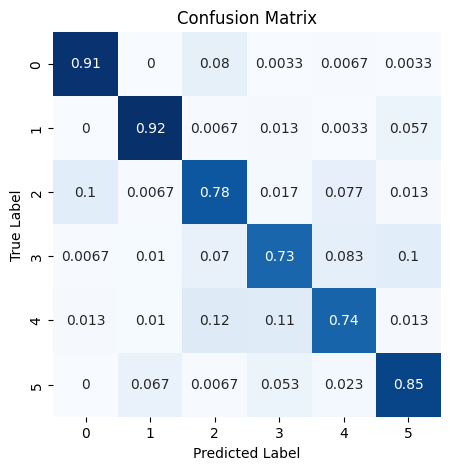

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       300
           1       0.91      0.92      0.91       300
           2       0.74      0.78      0.76       300
           3       0.79      0.73      0.76       300
           4       0.79      0.74      0.76       300
           5       0.82      0.85      0.83       300

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800



In [81]:

# Parameter grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}
best_model = None

# Manual grid search without cross-validation
for C in C_values:
    for gamma in gamma_values:
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        score = clf.score(X_test_scaled, y_test)  # accuracy on test set
        print(f"C={C}, gamma={gamma}, Accuracy={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}
            best_model = clf

# Final evaluation with best model
print("\nBest parameters found:", best_params)
y_pred = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


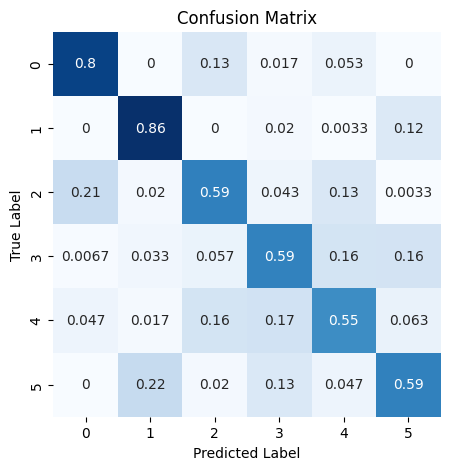

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       300
           1       0.75      0.86      0.80       300
           2       0.62      0.59      0.61       300
           3       0.61      0.59      0.60       300
           4       0.58      0.55      0.57       300
           5       0.63      0.59      0.61       300

    accuracy                           0.66      1800
   macro avg       0.66      0.66      0.66      1800
weighted avg       0.66      0.66      0.66      1800



In [82]:
clf = SVC(kernel='poly',degree=3,coef0=1)
clf.fit(X_train_scaled,y_train)
y_pred=clf.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
#sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))

C=0.1, degree=2, gamma=1, Accuracy=0.6617
C=0.1, degree=3, gamma=1, Accuracy=0.7750
C=0.1, degree=4, gamma=1, Accuracy=0.7922
C=1, degree=2, gamma=1, Accuracy=0.7094
C=1, degree=3, gamma=1, Accuracy=0.7750
C=1, degree=4, gamma=1, Accuracy=0.7922
C=10, degree=2, gamma=1, Accuracy=0.7400
C=10, degree=3, gamma=1, Accuracy=0.7750
C=10, degree=4, gamma=1, Accuracy=0.7922

Best parameters (poly kernel): {'C': 0.1, 'degree': 4, 'gamma': 1}


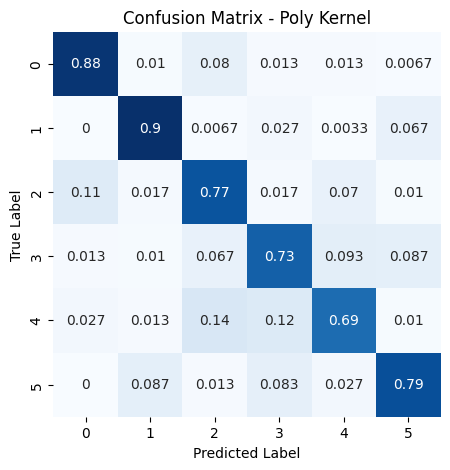

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       300
           1       0.87      0.90      0.88       300
           2       0.71      0.77      0.74       300
           3       0.74      0.73      0.73       300
           4       0.77      0.69      0.73       300
           5       0.81      0.79      0.80       300

    accuracy                           0.79      1800
   macro avg       0.79      0.79      0.79      1800
weighted avg       0.79      0.79      0.79      1800



In [83]:


# Parameter grid for polynomial kernel
C_values = [0.1, 1, 10]
degree_values = [2, 3, 4]
gamma=1

best_score = 0
best_params = {}
best_model = None

for C in C_values:
    for degree in degree_values:
        clf = SVC(kernel='poly', C=C, degree=degree, gamma=gamma)
        clf.fit(X_train_scaled, y_train)
        score = clf.score(X_test_scaled, y_test)
        print(f"C={C}, degree={degree}, gamma={gamma}, Accuracy={score:.4f}")
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'degree': degree, 'gamma': gamma}
            best_model = clf

print("\nBest parameters (poly kernel):", best_params)
y_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Poly Kernel")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


C=0.1, Accuracy=0.4850
C=1, Accuracy=0.4867
C=10, Accuracy=0.4933

Best parameters (linear kernel): {'C': 10}


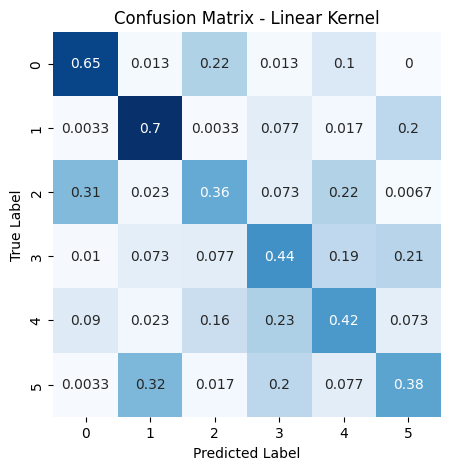

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       300
           1       0.61      0.70      0.65       300
           2       0.43      0.36      0.39       300
           3       0.42      0.44      0.43       300
           4       0.41      0.42      0.42       300
           5       0.44      0.38      0.41       300

    accuracy                           0.49      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.49      0.49      0.49      1800



In [84]:
# Parameter grid for linear kernel
C_values = [0.1, 1, 10]

best_score = 0
best_params = {}
best_model = None

for C in C_values:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X_train_scaled, y_train)
    score = clf.score(X_test_scaled, y_test)
    print(f"C={C}, Accuracy={score:.4f}")
    if score > best_score:
        best_score = score
        best_params = {'C': C}
        best_model = clf

print("\nBest parameters (linear kernel):", best_params)
y_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


### scratch

In [85]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [86]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [df[df['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = 500

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
df = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = df['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         500
Moderate                          500
Very Unhealthy                    500
Unhealthy for Sensitive Groups    500
Good                              500
Hazardous                         500
Name: count, dtype: int64

In [87]:

# Encode target labels
label_encoder = LabelEncoder()
df['pm25_category_encoded'] = label_encoder.fit_transform(df['pm25_category'])




selected_columns=[

'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos','pm25_category_encoded',
 'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
       'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
       'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy',
       'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
       'Iws_roll_crest',  'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest',  'Is_roll_entropy',
       'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
       'Ir_roll_crest', 'Ir_roll_entropy',


]


df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,19,21.0,1000.0,3.57,0,0,1,0.965926,0.258819,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
1,19,24.0,1006.0,0.89,0,0,3,0.866025,0.500000,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2,15,19.0,1007.0,9.83,0,0,1,0.965926,0.258819,1.224647e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
3,25,25.0,1004.0,1.79,0,0,0,0.707107,0.707107,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.333333,0.761387,0.816497,3.0,3.674235,7.097131e-01
4,-11,-9.0,1029.0,21.46,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,14,17.0,1021.0,0.89,0,0,3,0.500000,-0.866025,-8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2996,-11,-5.0,1024.0,0.89,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2997,12,17.0,1009.0,3.58,0,0,2,-0.707107,-0.707107,-8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2998,-9,-3.0,1023.0,6.26,0,0,1,0.707107,0.707107,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08


In [88]:

# Split features and target

#df=df.dropna()
X = df.drop(['pm25_category_encoded'],axis=1)
y = df['pm25_category_encoded']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs, stratify=y)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs, stratify=y_temp)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((2100, 51), (450, 51), (450, 51))

In [89]:
"""def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3):
    return (1 + np.dot(x1, x2)) ** degree

def rbf_kernel(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))


def train_dual_svm(X, y, kernel_func, C=1.0, epochs=100, lr=0.001):
    n = len(X)
    alpha = np.zeros(n)
    b = 0

    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_func(X[i], X[j])

    for _ in range(epochs):
        for i in range(n):
            gradient = 1 - y[i] * np.sum(alpha * y * K[:, i])
            alpha[i] += lr * gradient
            alpha[i] = np.clip(alpha[i], 0, C)

    # محاسبه b
    support_indices = np.where(alpha > 1e-5)[0]
    b = np.mean([y[i] - np.sum(alpha * y * K[:, i]) for i in support_indices])
    return alpha, b, support_indices



def predict(X_train, y_train, X_test, alpha, b, kernel_func):
    y_pred = []
    for x in X_test:
        s = 0
        for i in range(len(X_train)):
            s += alpha[i] * y_train[i] * kernel_func(X_train[i], x)
        y_pred.append(np.sign(s + b))
    return np.array(y_pred)
"""

'def linear_kernel(x1, x2):\n    return np.dot(x1, x2)\n\ndef polynomial_kernel(x1, x2, degree=3):\n    return (1 + np.dot(x1, x2)) ** degree\n\ndef rbf_kernel(x1, x2, sigma=1.0):\n    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))\n\n\ndef train_dual_svm(X, y, kernel_func, C=1.0, epochs=100, lr=0.001):\n    n = len(X)\n    alpha = np.zeros(n)\n    b = 0\n\n    K = np.zeros((n, n))\n    for i in range(n):\n        for j in range(n):\n            K[i, j] = kernel_func(X[i], X[j])\n\n    for _ in range(epochs):\n        for i in range(n):\n            gradient = 1 - y[i] * np.sum(alpha * y * K[:, i])\n            alpha[i] += lr * gradient\n            alpha[i] = np.clip(alpha[i], 0, C)\n\n    # محاسبه b\n    support_indices = np.where(alpha > 1e-5)[0]\n    b = np.mean([y[i] - np.sum(alpha * y * K[:, i]) for i in support_indices])\n    return alpha, b, support_indices\n\n\n\ndef predict(X_train, y_train, X_test, alpha, b, kernel_func):\n    y_pred = []\n    for x in X_tes

In [90]:

def linear_kernel( x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel( x, y, C=1.0, d=3):
    return (np.dot(x, y) + C) ** d

def gaussian_kernel( x, y, gamma=0.5):
    return np.exp(-gamma*np.linalg.norm(x - y) ** 2)

def sigmoid_kernel( x, y, alpha=1, C=0.01):
    a= alpha * np.dot(x, y) + C
    return np.tanh(a)

def SVM1(X, X_t, y, C, kernel_type, poly_params=(1, 4), RBF_params=0.5, sigmoid_params=(1, 0.01)):
    kernel_and_params=(kernel_type,poly_params, RBF_params, sigmoid_params,C)
    n_samples, n_features = X.shape
    # Compute the Gram matrix
    K = np.zeros((n_samples, n_samples))
    if kernel_type == 'linear':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = linear_kernel(X[i], X[j])
    elif kernel_type == 'polynomial':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = polynomial_kernel(X[i], X[j], poly_params[0], poly_params[1])
    elif kernel_type == 'RBF':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = gaussian_kernel(X[i], X[j], RBF_params)
    elif kernel_type == 'sigmoid':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = sigmoid_kernel(X[i], X[j], sigmoid_params[0], sigmoid_params[1])
    else:
        raise ValueError("Invalid kernel type")

    # construct P, q, A, b, G, h matrices for CVXOPT
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    # solve QP problem
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    # Lagrange multipliers
    a = np.ravel(solution['x'])
    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5  # some small threshold

        # Support vectors have non zero lagrange multipliers
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    numbers_of_sv=len(sv_y)
    # Bias (For linear it is the intercept):
    bias = 0
    for n in range(len(a)):
        # For all support vectors:
        bias += sv_y[n]
        bias -= np.sum(a * sv_y * K[ind[n], sv])
    bias = bias / len(a)

    # Weight vector
    if kernel_type == 'linear':
        w = np.zeros(n_features)
        for n in range(len(a)):
            w += a[n] * sv_y[n] * sv_x[n]
    else:
        w = None

    y_pred=0
    # Create the decision boundary for the plots. Calculates the hypothesis.
    if w is not None:
        y_pred = np.sign(np.dot(X_t, w) + bias)
    else:
        y_predict = np.zeros(len(X_t))
        for i in range(len(X_t)):
            s = 0
            for a1, sv_y1, sv1 in zip(a ,sv_y, sv_x):
                # a : Lagrange multipliers, sv : support vectors.
                # Hypothesis: sign(sum^S a * y * kernel + b)

                if kernel_type == 'linear':
                    s += a1 * sv_y1 * linear_kernel(X_t[i], sv1)
                if kernel_type=='RBF':
                    s += a1 * sv_y1 * gaussian_kernel(X_t[i], sv1, RBF_params)   # Kernel trick.
                if kernel_type == 'polynomial':
                    s += a1 * sv_y1 * polynomial_kernel(X_t[i], sv1, poly_params[0], poly_params[1])
                if kernel_type == 'sigmoid':
                    s=+ a1 * sv_y1 *sigmoid_kernel( X_t[i],  sv1, sigmoid_params[0], sigmoid_params[1])
            y_predict[i] = s
        y_pred = np.sign(y_predict + bias)

    return w, bias, solution,a, sv_x, sv_y, y_pred, kernel_and_params



def multiclass_svm(X,X_t, y, C, kernel_type, poly_params=(1, 4), RBF_params=0.5, sigmoid_params=(1, 0.01)):

    # Step 1: Identify unique class labels
    class_labels = list(set(y))

    # Step 2: Initialize classifiers dictionary
    classifiers = {}
    w_catch={} #catching w, b only for plot part
    b_catch={}
    a_catch={}
    sv_x_catch={}
    sv_y_catch={}
    # Step 3: Train binary SVM models for each required class combination
    for i,class_label in enumerate(class_labels):
        # Create binary labels for current class vs. all others
        binary_y = np.where(y == class_label, 1.0, -1.0)
        # Train SVM classifier for binary classification
        w, bias, _,a, sv_x, sv_y,prediction, kernel_and_params=SVM1(X,X_t, binary_y, C,kernel_type,poly_params, RBF_params, sigmoid_params)
        classifiers[class_label] = prediction
        w_catch[class_label]=w
        b_catch[class_label]=bias
        a_catch[class_label]=a
        sv_x_catch[class_label]=sv_x
        sv_y_catch[class_label]=sv_y
    '''
    a=np.hstack((classifiers[0],classifiers[1],classifiers[2]))
    np.save('array_file', a)
    '''



    def decision_function(X_t):
        decision_scores = np.zeros((X_t.shape[0], len(class_labels)))
        for i, label in enumerate(class_labels):
            decision_scores[:, i] = classifiers[label]
        return np.argmax(decision_scores, axis=1),kernel_and_params,w_catch, b_catch,classifiers
    return decision_function(X_t)






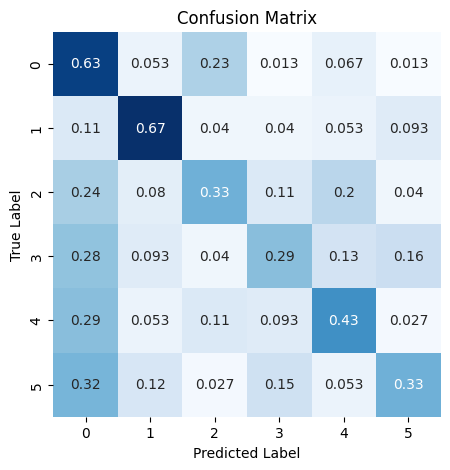

              precision    recall  f1-score   support

           0       0.34      0.63      0.44        75
           1       0.62      0.67      0.65        75
           2       0.43      0.33      0.38        75
           3       0.42      0.29      0.35        75
           4       0.46      0.43      0.44        75
           5       0.50      0.33      0.40        75

    accuracy                           0.45       450
   macro avg       0.46      0.45      0.44       450
weighted avg       0.46      0.45      0.44       450



In [94]:
model=multiclass_svm(X_train_scaled,X_test_scaled, y_train, 10,'polynomial', poly_params=(1, 3), RBF_params=0.1, sigmoid_params=(1, 0.01))
pred, kernel_and_params,w_catch, b_catch, classifiers=model

cm = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, pred))


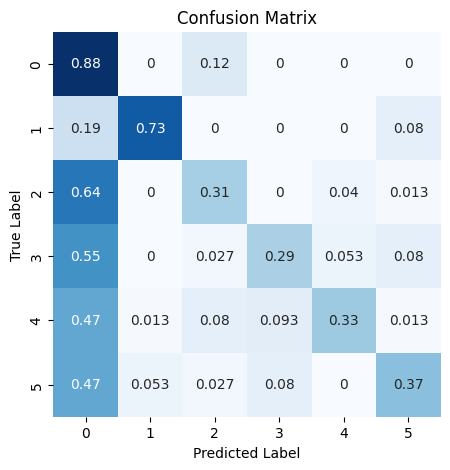

              precision    recall  f1-score   support

           0       0.28      0.88      0.42        75
           1       0.92      0.73      0.81        75
           2       0.55      0.31      0.39        75
           3       0.63      0.29      0.40        75
           4       0.78      0.33      0.47        75
           5       0.67      0.37      0.48        75

    accuracy                           0.49       450
   macro avg       0.64      0.49      0.50       450
weighted avg       0.64      0.49      0.50       450



In [92]:
model=multiclass_svm(X_train_scaled,X_test_scaled, y_train, 10,'RBF', poly_params=(0.1, 4), RBF_params=0.1, sigmoid_params=(1, 0.01)) 
pred, kernel_and_params,w_catch, b_catch, classifiers=model

cm = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, pred))

In [93]:
"""
models = {
    'Linear': linear_kernel,
    'Polynomial': lambda x1, x2: polynomial_kernel(x1, x2, degree=3),
    'RBF': lambda x1, x2: rbf_kernel(x1, x2, sigma=1.0)
}

for name, kernel in models.items():
    alpha, b, support = train_dual_svm(X_train_scaled, y_train.values, kernel)
    y_pred = predict(X_train_scaled, y_train.values, X_test_scaled, alpha, b, kernel)
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print(classification_report(y_test, y_pred))
    

"""

'\nmodels = {\n    \'Linear\': linear_kernel,\n    \'Polynomial\': lambda x1, x2: polynomial_kernel(x1, x2, degree=3),\n    \'RBF\': lambda x1, x2: rbf_kernel(x1, x2, sigma=1.0)\n}\n\nfor name, kernel in models.items():\n    alpha, b, support = train_dual_svm(X_train_scaled, y_train.values, kernel)\n    y_pred = predict(X_train_scaled, y_train.values, X_test_scaled, alpha, b, kernel)\n    \n    cm = confusion_matrix(y_test, y_pred, normalize=\'true\')\n    plt.figure(figsize=(5, 5))\n    sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)\n    plt.title("Confusion Matrix")\n    plt.xlabel("Predicted Label")\n    plt.ylabel("True Label")\n    plt.show()\n\n    print(classification_report(y_test, y_pred))\n    \n\n'

### 1.2.13

In [68]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [69]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [df[df['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = 2000

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
df = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = df['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         2000
Moderate                          2000
Very Unhealthy                    2000
Unhealthy for Sensitive Groups    2000
Good                              2000
Hazardous                         2000
Name: count, dtype: int64

In [70]:
selected_columns=[
    
'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos',
 'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
       'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
       'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy',
       'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
       'Iws_roll_crest',  'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest',  'Is_roll_entropy',
       'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
       'Ir_roll_crest', 'Ir_roll_entropy',
       'pm2.5_lag24', 'pm2.5_roll_mean_24h', 'pm2.5_roll_std',
       'pm2.5_roll_rms', 'pm2.5_roll_peak', 'pm2.5_roll_crest',
      'pm2.5_roll_entropy','pm2.5'
]



df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Ir_roll_crest,Ir_roll_entropy,pm2.5_lag24,pm2.5_roll_mean_24h,pm2.5_roll_std,pm2.5_roll_rms,pm2.5_roll_peak,pm2.5_roll_crest,pm2.5_roll_entropy,pm2.5
0,19,21.0,1000.0,3.57,0,0,1,0.965926,0.258819,-5.000000e-01,...,0.000000,2.162327e-08,49.0,44.125000,18.646162,47.751527,80.0,1.675339,2.210254,80.0
1,19,24.0,1006.0,0.89,0,0,3,0.866025,0.500000,-5.000000e-01,...,0.000000,2.162327e-08,21.0,28.583333,17.430400,33.289137,80.0,2.403186,1.596671,80.0
2,15,19.0,1007.0,9.83,0,0,1,0.965926,0.258819,1.224647e-16,...,0.000000,2.162327e-08,31.0,48.708333,35.043425,59.576631,134.0,2.249204,1.535856,87.0
3,25,25.0,1004.0,1.79,0,0,0,0.707107,0.707107,-5.000000e-01,...,3.674235,7.097131e-01,90.0,79.750000,22.545124,82.747608,130.0,1.571042,2.084201,75.0
4,-11,-9.0,1029.0,21.46,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.000000,2.162327e-08,71.0,155.125000,47.810598,162.032018,222.0,1.370100,2.138333,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-9,0.0,1027.0,2.67,0,0,3,-0.258819,-0.965926,8.660254e-01,...,0.000000,2.162327e-08,22.0,113.166667,63.558030,129.143331,252.0,1.951320,2.084201,252.0
11996,-6,-3.0,1027.0,1.78,0,0,3,-0.258819,0.965926,5.000000e-01,...,0.000000,2.162327e-08,348.0,397.958333,43.061613,400.184801,469.0,1.171959,2.152492,446.0
11997,23,28.0,1011.0,3.58,0,2,2,-0.258819,-0.965926,-8.660254e-01,...,4.381780,3.445983e-01,121.0,224.041667,80.719848,237.568674,337.0,1.418537,1.968677,309.0
11998,-2,6.0,1009.0,0.89,0,0,0,-0.500000,0.866025,1.000000e+00,...,0.000000,2.162327e-08,196.0,269.250000,53.792880,274.351356,416.0,1.516304,1.642698,415.0


In [71]:

# Split features and target

df=df.dropna()
X = df.drop(['pm2.5'],axis=1)
y = df['pm2.5']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((8400, 58), (1800, 58), (1800, 58))

In [72]:
reg = SVR(kernel='rbf',gamma=0.1,C=100)
reg.fit(X_train_scaled,y_train)
y_pred=reg.predict(X_test_scaled)
 

acc = reg.score(X_test_scaled,y_test)
acc

0.8889853124497524

In [ ]:
# Parameter grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}
best_model = None

# Manual grid search without cross-validation
for C in C_values:
    for gamma in gamma_values:
        reg = SVR(kernel='rbf', C=C, gamma=gamma)
        reg.fit(X_train_scaled, y_train)
        y_pred = reg.predict(X_test_scaled)
        score = reg.score(X_test_scaled, y_test)  # accuracy on test set
        print(f"C={C}, gamma={gamma}, Accuracy={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}
            best_model = reg

# Final evaluation with best model
print("\nBest parameters found:", best_params)
y_pred = best_model.predict(X_test_scaled)



C=0.1, gamma=1, Accuracy=-0.2644
C=0.1, gamma=0.1, Accuracy=-0.2365
C=0.1, gamma=0.01, Accuracy=0.0377
C=0.1, gamma=0.001, Accuracy=-0.1831
C=1, gamma=1, Accuracy=-0.2473
C=1, gamma=0.1, Accuracy=-0.0177
C=1, gamma=0.01, Accuracy=0.6557
C=1, gamma=0.001, Accuracy=0.2969
C=10, gamma=1, Accuracy=-0.0989
C=10, gamma=0.1, Accuracy=0.5749
C=10, gamma=0.01, Accuracy=0.8045
C=10, gamma=0.001, Accuracy=0.7142
C=100, gamma=1, Accuracy=0.5028
C=100, gamma=0.1, Accuracy=0.8890
C=100, gamma=0.01, Accuracy=0.8837
C=100, gamma=0.001, Accuracy=0.8031

Best parameters found: {'C': 100, 'gamma': 0.1}


0.7206601997575086

In [73]:
reg = SVR(kernel='poly',degree=4,gamma=1,C=0.1)
reg.fit(X_train_scaled,y_train)
y_pred=reg.predict(X_test_scaled)
 

acc = reg.score(X_test_scaled,y_test)
acc

0.7206601997575086

### 1.2.15 (PSO)

In [95]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [96]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [df[df['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = 2000

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
df = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = df['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         2000
Moderate                          2000
Very Unhealthy                    2000
Unhealthy for Sensitive Groups    2000
Good                              2000
Hazardous                         2000
Name: count, dtype: int64

In [97]:

# Encode target labels
label_encoder = LabelEncoder()
df['pm25_category_encoded'] = label_encoder.fit_transform(df['pm25_category'])




selected_columns=[

'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos','pm25_category_encoded',
 'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
       'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
       'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy',
       'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
       'Iws_roll_crest',  'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest',  'Is_roll_entropy',
       'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
       'Ir_roll_crest', 'Ir_roll_entropy',


]


df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,19,21.0,1000.0,3.57,0,0,1,0.965926,0.258819,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
1,19,24.0,1006.0,0.89,0,0,3,0.866025,0.500000,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2,15,19.0,1007.0,9.83,0,0,1,0.965926,0.258819,1.224647e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
3,25,25.0,1004.0,1.79,0,0,0,0.707107,0.707107,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.333333,0.761387,0.816497,3.0,3.674235,7.097131e-01
4,-11,-9.0,1029.0,21.46,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-9,0.0,1027.0,2.67,0,0,3,-0.258819,-0.965926,8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11996,-6,-3.0,1027.0,1.78,0,0,3,-0.258819,0.965926,5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11997,23,28.0,1011.0,3.58,0,2,2,-0.258819,-0.965926,-8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.125000,0.448427,0.456435,2.0,4.381780,3.445983e-01
11998,-2,6.0,1009.0,0.89,0,0,0,-0.500000,0.866025,1.000000e+00,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08


In [98]:

# Split features and target

#df=df.dropna()
X = df.drop(['pm25_category_encoded'],axis=1)
y = df['pm25_category_encoded']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs, stratify=y)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs, stratify=y_temp)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((8400, 51), (1800, 51), (1800, 51))

In [99]:
def fitness_function(params):
    C, gamma = params
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    return -accuracy_score(y_test, y_pred)  # چون PSO کمینه‌سازی می‌کند


In [100]:
lb = [0.1, 0.01]
ub = [100, 1]

best_params, _ = pso(fitness_function, lb, ub, swarmsize=20, maxiter=30)
C_opt, gamma_opt = best_params

clf_opt = SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
clf_opt.fit(X_train_scaled, y_train)
y_pred_opt = clf_opt.predict(X_test_scaled)
acc_opt = accuracy_score(y_test, y_pred_opt)




Stopping search: maximum iterations reached --> 30


In [101]:
C_opt,gamma_opt

(71.52809506216477, 0.07263745094688884)

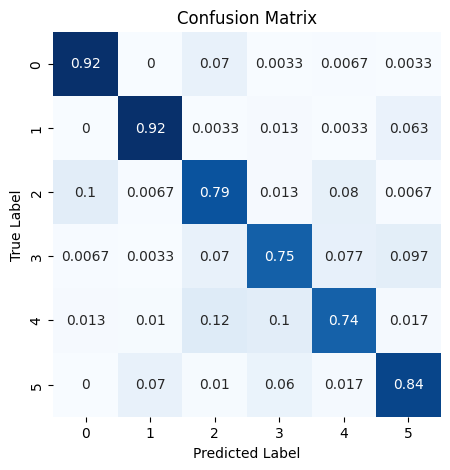

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       300
           1       0.91      0.92      0.91       300
           2       0.75      0.79      0.77       300
           3       0.80      0.75      0.77       300
           4       0.80      0.74      0.77       300
           5       0.82      0.84      0.83       300

    accuracy                           0.83      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.83      0.83      0.83      1800



In [102]:
cm = confusion_matrix(y_test, y_pred_opt, normalize='true')
plt.figure(figsize=(5, 5))
#sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred_opt))

## 1.3 (DE opt)

In [103]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [104]:
# جدا کردن داده‌ها بر اساس کلاس
grouped_data = [df[df['pm25_category'] == category] for category in class_counts.index]

# تعیین بیشترین اندازه برای بالانس کردن
min_count = 2000

# اعمال upsampling روی همه دسته‌ها
balanced_groups = [
    resample(group, replace=True, n_samples=min_count, random_state=rs)
    for group in grouped_data
]

# ترکیب مجدد داده‌های بالانس‌شده
df = pd.concat(balanced_groups).reset_index(drop=True)

# بررسی تعادل جدید کلاس‌ها
balanced_class_counts = df['pm25_category'].value_counts()
balanced_class_counts


pm25_category
Unhealthy                         2000
Moderate                          2000
Very Unhealthy                    2000
Unhealthy for Sensitive Groups    2000
Good                              2000
Hazardous                         2000
Name: count, dtype: int64

In [105]:

# Encode target labels
label_encoder = LabelEncoder()
df['pm25_category_encoded'] = label_encoder.fit_transform(df['pm25_category'])




selected_columns=[

'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos','pm25_category_encoded',
 'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
       'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
       'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy',
       'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
       'Iws_roll_crest',  'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest',  'Is_roll_entropy',
       'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
       'Ir_roll_crest', 'Ir_roll_entropy',


]


df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,19,21.0,1000.0,3.57,0,0,1,0.965926,0.258819,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
1,19,24.0,1006.0,0.89,0,0,3,0.866025,0.500000,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2,15,19.0,1007.0,9.83,0,0,1,0.965926,0.258819,1.224647e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
3,25,25.0,1004.0,1.79,0,0,0,0.707107,0.707107,-5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.333333,0.761387,0.816497,3.0,3.674235,7.097131e-01
4,-11,-9.0,1029.0,21.46,0,0,1,0.965926,0.258819,-2.449294e-16,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-9,0.0,1027.0,2.67,0,0,3,-0.258819,-0.965926,8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11996,-6,-3.0,1027.0,1.78,0,0,3,-0.258819,0.965926,5.000000e-01,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
11997,23,28.0,1011.0,3.58,0,2,2,-0.258819,-0.965926,-8.660254e-01,...,0.0,0.0,0.0,2.162327e-08,0.125000,0.448427,0.456435,2.0,4.381780,3.445983e-01
11998,-2,6.0,1009.0,0.89,0,0,0,-0.500000,0.866025,1.000000e+00,...,0.0,0.0,0.0,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08


In [106]:

# Split features and target

#df=df.dropna()
X = df.drop(['pm25_category_encoded'],axis=1)
y = df['pm25_category_encoded']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs, stratify=y)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs, stratify=y_temp)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((8400, 51), (1800, 51), (1800, 51))

In [ ]:

def objective(params):
    C, gamma = params
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    score = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
    return -score  # چون DE مینیمم می‌کند، ما ماکزیمم دقت را منفی می‌کنیم



bounds = [(0.1, 100),   # C
          (1e-2, 1)]    # gamma

result = differential_evolution(objective, bounds, strategy='best1bin',
                                maxiter=20, popsize=15, tol=1e-4, seed=42)

best_C, best_gamma = result.x
print(f'Best parameters found by DE:\n C = {best_C:.4f}, gamma = {best_gamma:.6f}')


model_de = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
model_de.fit(X_train_scaled, y_train)
y_pred_de = model_de.predict(X_test_scaled)



Best parameters found by DE:
 C = 34.0088, gamma = 0.051721


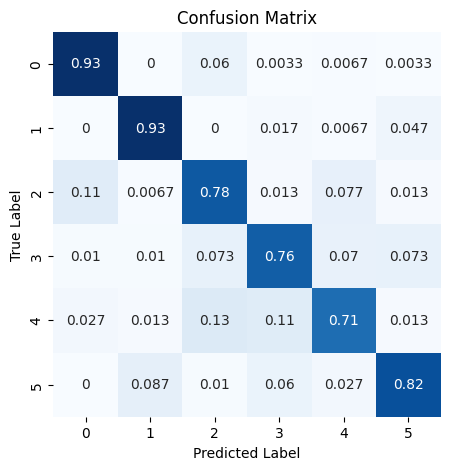

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       300
           1       0.89      0.93      0.91       300
           2       0.74      0.78      0.76       300
           3       0.79      0.76      0.78       300
           4       0.79      0.71      0.75       300
           5       0.84      0.82      0.83       300

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800



In [108]:
cm = confusion_matrix(y_test, y_pred_de, normalize='true')
plt.figure(figsize=(5, 5))
#sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred_de))

## 1.3.6 final

In [109]:
df = balanced_data.copy()
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,season,weekday_name
0,33891,2013,11,13,2,106.0,-4,3.0,1024.0,SE,...,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,Autumn,Wednesday
1,2547,2010,4,17,2,103.0,3,6.0,1023.0,SE,...,0.500000,8.660254e-01,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,-0.974928,-0.222521,Spring,Saturday
2,38804,2014,6,5,19,59.0,14,31.0,1002.0,SE,...,-0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.848644,0.528964,0.433884,-0.900969,Summer,Thursday
3,17782,2012,1,11,21,120.0,-15,-4.0,1032.0,SE,...,-0.707107,7.071068e-01,5.000000e-01,8.660254e-01,0.790776,-0.612106,0.974928,-0.222521,Winter,Wednesday
4,32758,2013,9,26,21,107.0,10,14.0,1014.0,SE,...,-0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,-0.848644,0.528964,0.433884,-0.900969,Autumn,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,7724,2010,11,18,19,476.0,2,5.0,1018.0,cv,...,-0.965926,2.588190e-01,-5.000000e-01,8.660254e-01,-0.485302,-0.874347,0.433884,-0.900969,Autumn,Thursday
18656,15503,2011,10,8,22,329.0,15,16.0,1017.0,cv,...,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,0.998717,-0.050649,-0.974928,-0.222521,Autumn,Saturday
18657,36126,2014,2,14,5,259.0,-11,-8.0,1028.0,NW,...,0.965926,2.588190e-01,8.660254e-01,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,Winter,Friday
18658,35213,2014,1,7,4,256.0,-6,-3.0,1025.0,NW,...,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.988468,0.151428,0.781831,0.623490,Winter,Tuesday


In [110]:

# Encode target labels
label_encoder = LabelEncoder()
df['pm25_category_encoded'] = label_encoder.fit_transform(df['pm25_category'])




selected_columns=[

'DEWP', 'TEMP', 'PRES',
'Iws', 'Is', 'Ir', 'cbwd_code', 'hour_sin', 'hour_cos',
'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
'weekday_cos','pm25_category_encoded',
 'PRES_roll_mean_24h', 'PRES_roll_std', 'PRES_roll_rms',
       'PRES_roll_peak', 'PRES_roll_crest',
       'PRES_roll_entropy', 'DEWP_roll_mean_24h', 'DEWP_roll_std',
       'DEWP_roll_rms', 'DEWP_roll_peak', 'DEWP_roll_crest',
       'DEWP_roll_entropy', 'TEMP_roll_mean_24h',
       'TEMP_roll_std', 'TEMP_roll_rms', 'TEMP_roll_peak', 'TEMP_roll_crest',
       'TEMP_roll_entropy',
       'Iws_roll_mean_24h', 'Iws_roll_std', 'Iws_roll_rms', 'Iws_roll_peak',
       'Iws_roll_crest',  'Iws_roll_entropy',
       'Is_roll_mean_24h', 'Is_roll_std', 'Is_roll_rms', 'Is_roll_peak',
       'Is_roll_crest',  'Is_roll_entropy',
       'Ir_roll_mean_24h', 'Ir_roll_std', 'Ir_roll_rms', 'Ir_roll_peak',
       'Ir_roll_crest', 'Ir_roll_entropy',


]


df=df[selected_columns]
df

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_code,hour_sin,hour_cos,month_sin,...,Is_roll_rms,Is_roll_peak,Is_roll_crest,Is_roll_entropy,Ir_roll_mean_24h,Ir_roll_std,Ir_roll_rms,Ir_roll_peak,Ir_roll_crest,Ir_roll_entropy
0,-4,3.0,1024.0,4.47,0,0,2,0.500000,8.660254e-01,-5.000000e-01,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
1,3,6.0,1023.0,61.23,0,0,2,0.500000,8.660254e-01,8.660254e-01,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
2,14,31.0,1002.0,8.04,0,0,2,-0.965926,2.588190e-01,1.224647e-16,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
3,-15,-4.0,1032.0,34.42,0,0,2,-0.707107,7.071068e-01,5.000000e-01,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
4,10,14.0,1014.0,1.79,0,0,2,-0.707107,7.071068e-01,-1.000000e+00,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,2,5.0,1018.0,0.89,0,0,3,-0.965926,2.588190e-01,-5.000000e-01,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
18656,15,16.0,1017.0,0.89,0,0,3,-0.500000,8.660254e-01,-8.660254e-01,...,0.000000,0.0,0.000000,2.162327e-08,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
18657,-11,-8.0,1028.0,0.89,0,0,1,0.965926,2.588190e-01,8.660254e-01,...,0.456435,2.0,4.381780,3.445983e-01,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08
18658,-6,-3.0,1025.0,2.68,0,0,1,0.866025,5.000000e-01,5.000000e-01,...,0.763763,3.0,3.927922,5.140967e-01,0.000000,0.000000,0.000000,0.0,0.000000,2.162327e-08


In [111]:

# Split features and target

#df=df.dropna()
X = df.drop(['pm25_category_encoded'],axis=1)
y = df['pm25_category_encoded']

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=rs, stratify=y)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=rs, stratify=y_temp)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((13062, 51), (2799, 51), (2799, 51))

C=0.1, gamma=1, Accuracy=0.4784
C=0.1, gamma=0.1, Accuracy=0.5059
C=0.1, gamma=0.01, Accuracy=0.4527
C=0.1, gamma=0.001, Accuracy=0.3794
C=1, gamma=1, Accuracy=0.6774
C=1, gamma=0.1, Accuracy=0.7278
C=1, gamma=0.01, Accuracy=0.5366
C=1, gamma=0.001, Accuracy=0.4455
C=10, gamma=1, Accuracy=0.6924
C=10, gamma=0.1, Accuracy=0.7728
C=10, gamma=0.01, Accuracy=0.6395
C=10, gamma=0.001, Accuracy=0.5002
C=100, gamma=1, Accuracy=0.6924
C=100, gamma=0.1, Accuracy=0.7678
C=100, gamma=0.01, Accuracy=0.7113
C=100, gamma=0.001, Accuracy=0.5527

Best parameters found: {'C': 10, 'gamma': 0.1}


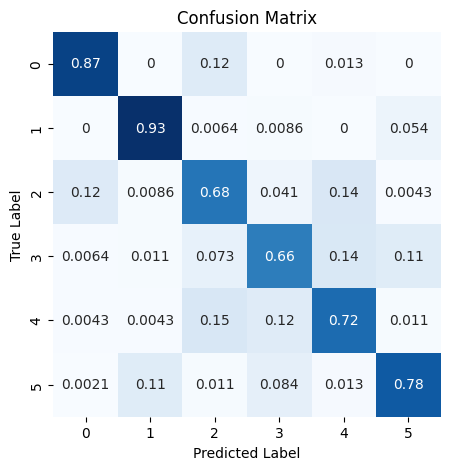

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       467
           1       0.88      0.93      0.90       466
           2       0.66      0.68      0.67       467
           3       0.73      0.66      0.69       467
           4       0.70      0.72      0.71       466
           5       0.81      0.78      0.80       466

    accuracy                           0.77      2799
   macro avg       0.77      0.77      0.77      2799
weighted avg       0.77      0.77      0.77      2799



In [112]:

# Parameter grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}
best_model = None

# Manual grid search without cross-validation
for C in C_values:
    for gamma in gamma_values:
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        score = clf.score(X_test_scaled, y_test)  # accuracy on test set
        print(f"C={C}, gamma={gamma}, Accuracy={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}
            best_model = clf

# Final evaluation with best model
print("\nBest parameters found:", best_params)
y_pred = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))
